# Beyond Words: Classifying Bangla Suicide Risk

# 📝 Notebook Details

**Author:** Jahangir Hussen  
**Email:** jahangirhussen.programmer@gmail.com  
**Project:** Bangla Tweet Classification (ML & Deep Learning)  
**Date:** 20th October 2025  
**Purpose:**  
- Analyze Bangla tweets for intention classification  
- Implement multiple ML models (LinearSVC, LogisticRegression, RandomForest, XGBoost, PassiveAggressive, Perceptron, SGD, RidgeClassifier)  
- Implement deep learning models (LSTM, BiLSTM, CNN, GRU)  
- Create ensemble models for improved performance  
- Visualize data distributions and model metrics


# Final Book

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tweet-06-sep/combined_df_tweet_sep_6.csv
/kaggle/input/bengali-suicidal-intention-classifier/Bangla Suicidal Intention Dataset.csv


# Library Import and Data Preview


In [2]:
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import time
import os
import random
import warnings

from scipy.sparse import vstack

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Conv1D, GlobalMaxPooling1D, GRU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings("ignore")
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

df = pd.read_csv("/kaggle/input/bengali-suicidal-intention-classifier/Bangla Suicidal Intention Dataset.csv")
df.head()


2025-10-21 05:52:45.262912: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761025965.448219      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761025965.502632      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


,Bangla,intention
0,আমার জীবন অর্থহীন আমি শুধু আমার জীবন শেষ করতে ...,1.0
1,বিড়বিড় করে আমি কয়েক মাস ধরে প্রতিদিন নিজের ...,1.0
2,কাজের দাস আমি সত্যিই মনে করি আমার জীবনের একমাত...,1.0
3,আমি আপনার সাথে এটি দেখতে চাই আমি আপনাকে মিস কর...,0.0
4,আমি গিয়ার এবং খাঁজ প্রচার করতে যেতে চাই কিন্ত...,0.0


##  Data Preview and Visualization


Data Shape: (13288, 2)
Null Values Check:
Bangla       169
intention    169
dtype: int64

Intention Value Counts:
intention
1.0    6656
0.0    6463
Name: count, dtype: int64


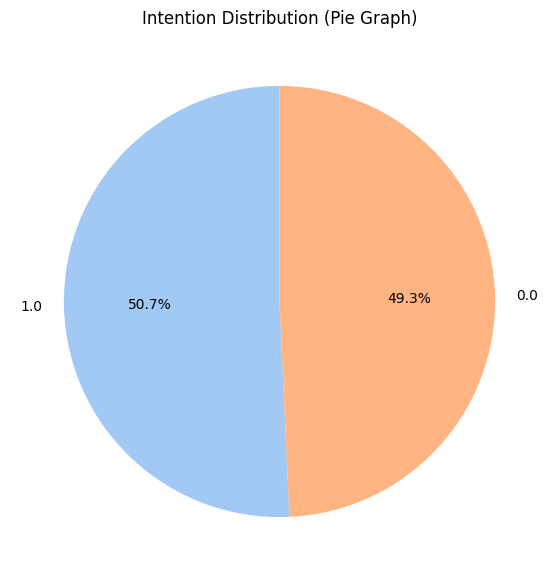

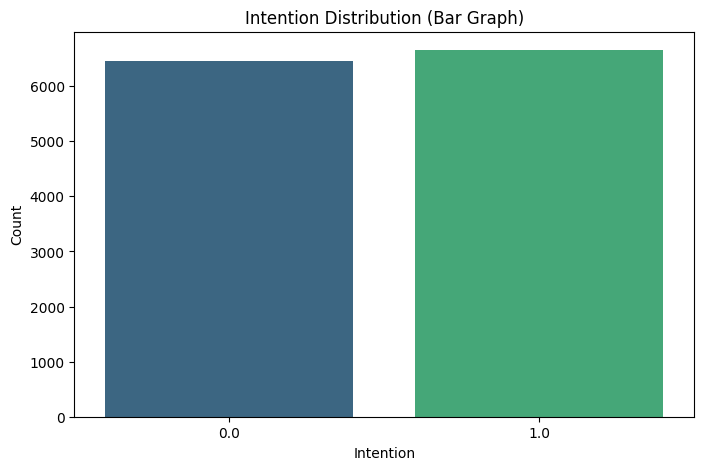

In [3]:
print("\nData Shape:", df.shape)
print("Null Values Check:")
print(df.isnull().sum())
print("\nIntention Value Counts:")
intention_counts = df['intention'].value_counts()
print(intention_counts)

plt.figure(figsize=(7, 7))
plt.pie(intention_counts, labels=intention_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title('Intention Distribution (Pie Graph)')
plt.savefig('/kaggle/working/intention_pie_graph.png')
plt.show()
plt.close()

plt.figure(figsize=(8, 5))
sns.barplot(x=intention_counts.index, y=intention_counts.values, palette='viridis')
plt.title('Intention Distribution (Bar Graph)')
plt.xlabel('Intention')
plt.ylabel('Count')
plt.savefig('/kaggle/working/intention_bar_graph.png')
plt.show()
plt.close()


# Data Cleaning


In [4]:
def remove_emails(x): 
    return re.sub(r'([a-z0-9+._-]+@[a-z0-9+._-]+\.[a-z0-9+_-]+)', "", str(x))

def remove_punctuation(x): 
    return re.sub(r'[।,!?\"\':;]+', "", str(x))

def normalize_space(x): 
    return re.sub(r'\s+', ' ', str(x)).strip()

df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df = df.drop_duplicates(subset=[ 'intention', 'Bangla'], keep='first')
df['Bangla'] = df['Bangla'].fillna("").apply(remove_emails).apply(remove_punctuation).apply(normalize_space)
df = df.dropna(subset=['intention', 'Bangla'])

print("\n--- After Data Cleaning ---")
print("Data Shape:", df.shape)
print("Data Size (in memory):", df.memory_usage(deep=True).sum())
print("Null Values Check:")
print(df.isnull().sum())



--- After Data Cleaning ---
Data Shape: (12823, 2)
Data Size (in memory): 8521147
Null Values Check:
Bangla       0
intention    0
dtype: int64


# Feature Extraction and Train-Test Split


In [5]:
tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1,3), analyzer='char')
X = tfidf.fit_transform(df['Bangla'])
y = df['intention']

print("\nTF-IDF Feature Shape:", X.shape)

x_train_ml, x_test_ml, y_train_ml, y_test_ml = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

print("ML Train/Test Split Shapes:")
print(f"Train (X, y): {x_train_ml.shape}, {y_train_ml.shape}")
print(f"Test (X, y): {x_test_ml.shape}, {y_test_ml.shape}")



TF-IDF Feature Shape: (12823, 20000)
ML Train/Test Split Shapes:
Train (X, y): (10258, 20000), (10258,)
Test (X, y): (2565, 20000), (2565,)


# ML Model Evaluation Function


In [6]:
def evaluate_model_save_ml(model, model_name, x_train, x_test, y_train, y_test):
    start_time = time.time()
    model.fit(x_train, y_train)
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    end_time = time.time()
    runtime = end_time - start_time

    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    
    X_full = vstack([x_train, x_test])
    y_full = np.hstack([y_train, y_test])
    y_full_pred = model.predict(X_full)
    overall_acc = accuracy_score(y_full, y_full_pred)
    
    precision = precision_score(y_test, y_test_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_test_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_test_pred, average='weighted', zero_division=0)

    print(f"\n===== {model_name} (ML) =====")
    print(f"Train Accuracy : {train_acc:.4f}")
    print(f"Test Accuracy  : {test_acc:.4f}")
    print(f"Precision      : {precision:.4f}")
    print(f"Recall         : {recall:.4f}")
    print(f"F1 Score       : {f1:.4f}")
    print(f"Runtime (sec)  : {runtime:.2f}")


    cm = confusion_matrix(y_test, y_test_pred)
    print("\nConfusion Matrix (Text Output):\n", cm)
    
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.savefig(f"/kaggle/working/{model_name}_confusion_matrix.png")
    plt.show()
    plt.close()

    metrics = ['Train Acc','Test Acc','Precision','Recall','F1']
    values = [train_acc, test_acc, precision, recall, f1]
    plt.figure(figsize=(8,5))
    sns.barplot(x=metrics, y=values, palette='crest')
    plt.ylim(0, 1.05)
    plt.title(f"Metrics - {model_name}")
    plt.savefig(f"/kaggle/working/{model_name}_metrics_bar.png")
    plt.show()
    plt.close()

    train_sizes, train_scores, test_scores = learning_curve(
        model, X_full, y_full, cv=5, n_jobs=-1, scoring='accuracy', random_state=SEED
    )
    plt.figure(figsize=(6,4))
    plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color='blue', label='Train Acc')
    plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color='green', label='Validation Acc')
    plt.title(f"Learning Curve (Accuracy) - {model_name}")
    plt.xlabel("Training Samples")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()
    plt.savefig(f"/kaggle/working/{model_name}_learning_curve.png")
    plt.show()
    plt.close()


# LinearSVC Model Training and Evaluation


===== LinearSVC (ML) =====
Train Accuracy : 0.9754
Test Accuracy  : 0.9146
Precision      : 0.9147
Recall         : 0.9146
F1 Score       : 0.9146
Runtime (sec)  : 0.32

Confusion Matrix (Text Output):
 [[1186  100]
 [ 119 1160]]


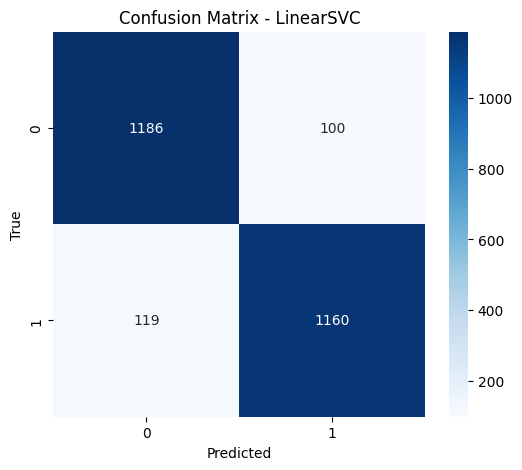

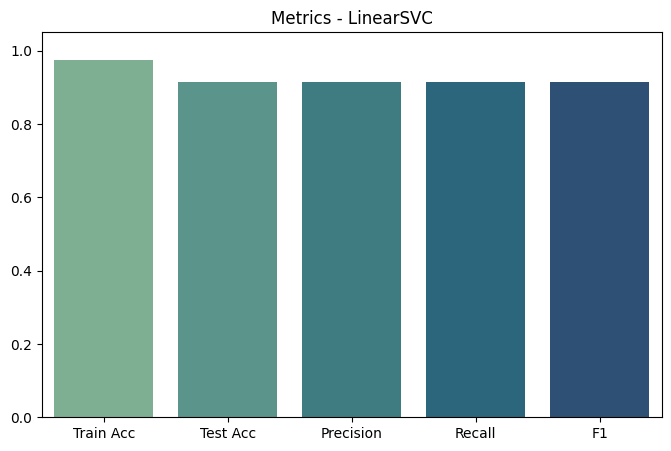

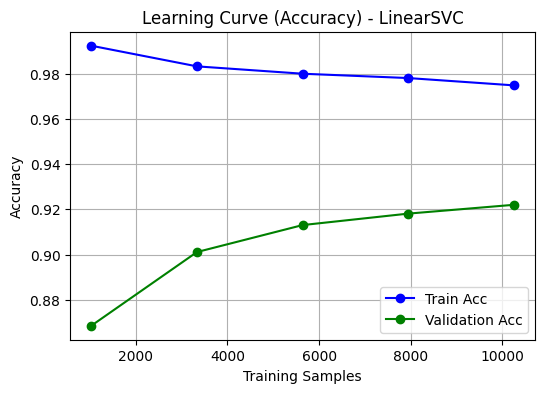

In [7]:
model_svc = LinearSVC(random_state=SEED)
evaluate_model_save_ml(model_svc, "LinearSVC", x_train_ml, x_test_ml, y_train_ml, y_test_ml)

# Logistic Regression Model Training and Evaluation



===== LogisticRegression (ML) =====
Train Accuracy : 0.9240
Test Accuracy  : 0.8869
Precision      : 0.8874
Recall         : 0.8869
F1 Score       : 0.8869
Runtime (sec)  : 1.11

Confusion Matrix (Text Output):
 [[1163  123]
 [ 167 1112]]


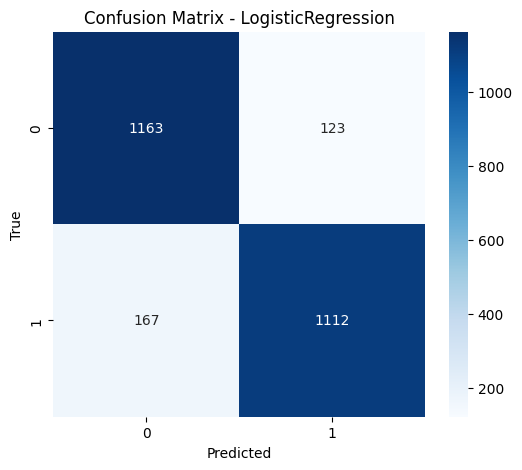

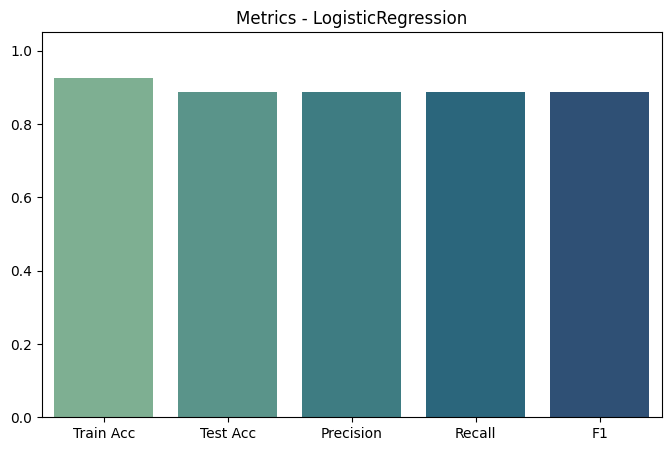

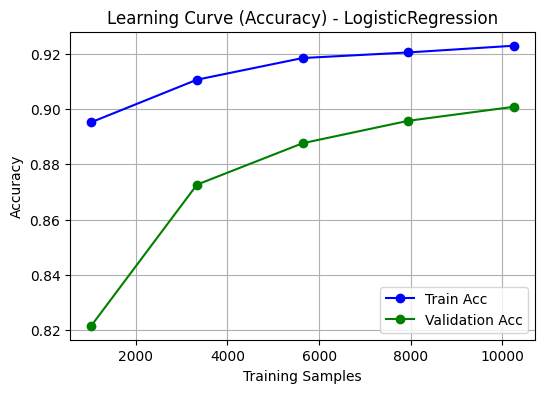

In [8]:
model_lr = LogisticRegression(max_iter=500, random_state=SEED)
evaluate_model_save_ml(model_lr, "LogisticRegression", x_train_ml, x_test_ml, y_train_ml, y_test_ml)


# SGD Classifier Training and Evaluation



===== SGDClassifier (ML) =====
Train Accuracy : 0.9240
Test Accuracy  : 0.8881
Precision      : 0.8882
Recall         : 0.8881
F1 Score       : 0.8881
Runtime (sec)  : 0.16

Confusion Matrix (Text Output):
 [[1154  132]
 [ 155 1124]]


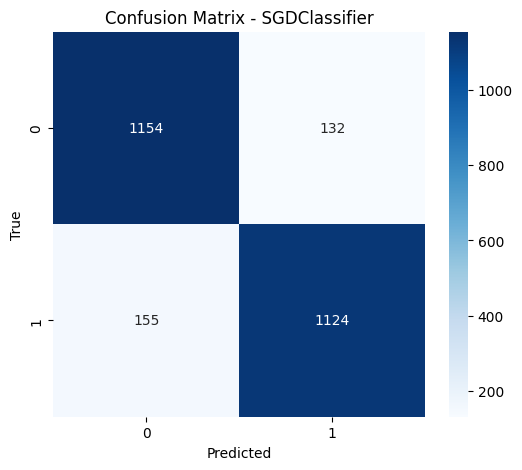

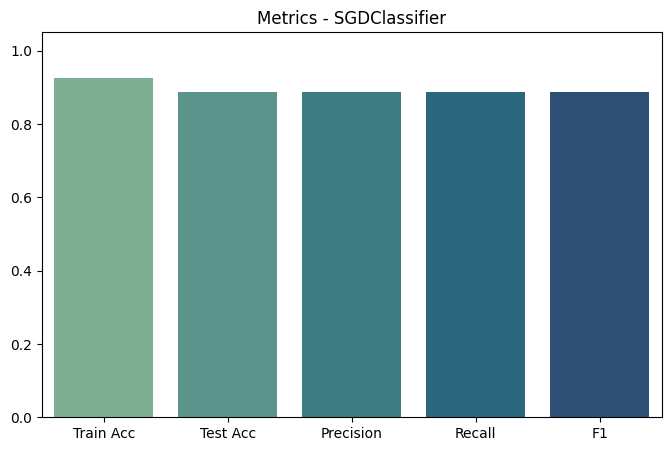

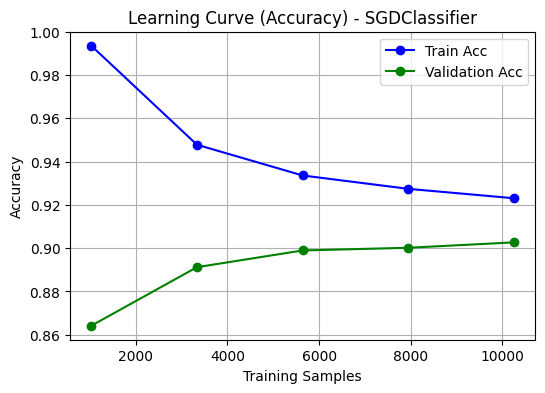

In [9]:
from sklearn.linear_model import SGDClassifier

model_sgd = SGDClassifier(loss='log_loss', max_iter=1000, random_state=SEED, tol=1e-3)
evaluate_model_save_ml(model_sgd, "SGDClassifier", x_train_ml, x_test_ml, y_train_ml, y_test_ml)


# Perceptron Model Training and Evaluation



===== Perceptron (ML) =====
Train Accuracy : 0.9789
Test Accuracy  : 0.8846
Precision      : 0.8873
Recall         : 0.8846
F1 Score       : 0.8844
Runtime (sec)  : 0.15

Confusion Matrix (Text Output):
 [[1192   94]
 [ 202 1077]]


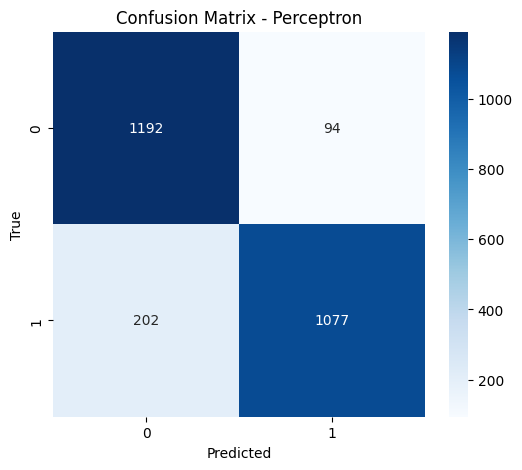

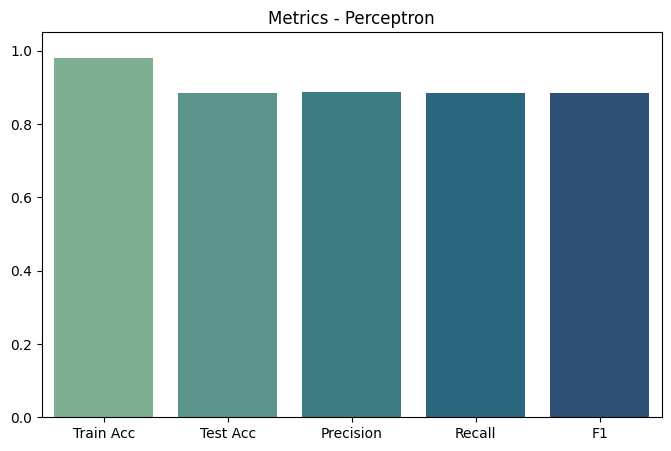

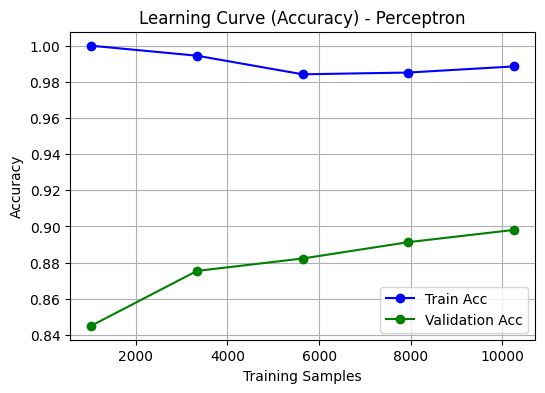

In [10]:
from sklearn.linear_model import Perceptron

model_pc = Perceptron(max_iter=1000, random_state=SEED, tol=1e-3)
evaluate_model_save_ml(model_pc, "Perceptron", x_train_ml, x_test_ml, y_train_ml, y_test_ml)


# Random Forest Model Training and Evaluation



===== RandomForest (ML) =====
Train Accuracy : 0.9997
Test Accuracy  : 0.8955
Precision      : 0.9007
Recall         : 0.8955
F1 Score       : 0.8952
Runtime (sec)  : 19.37

Confusion Matrix (Text Output):
 [[1225   61]
 [ 207 1072]]


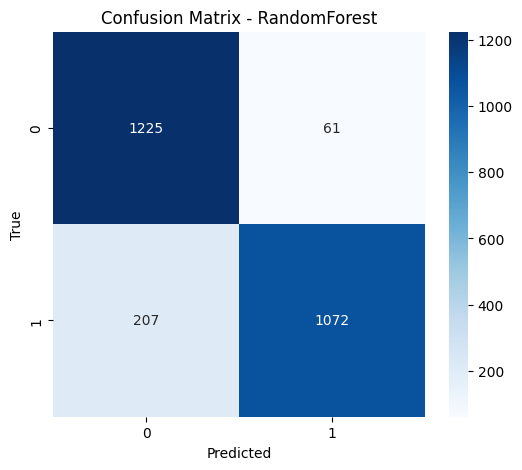

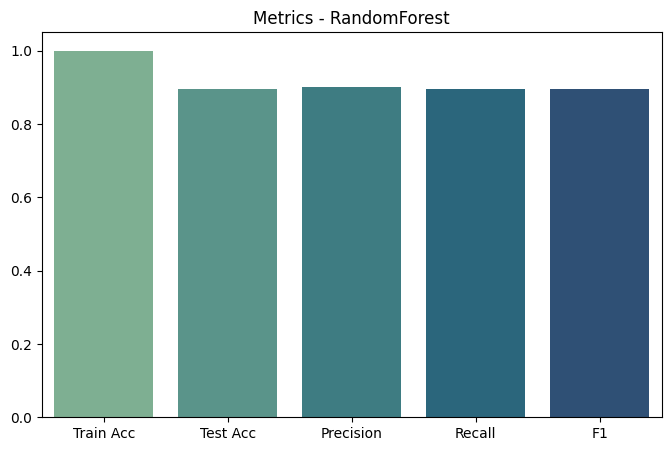

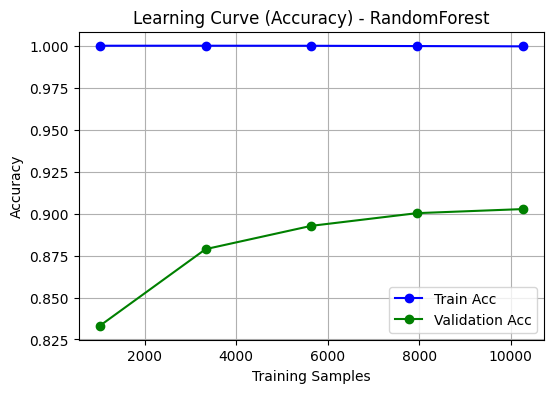

In [11]:
model_rf = RandomForestClassifier(n_estimators=100, random_state=SEED)
evaluate_model_save_ml(model_rf, "RandomForest", x_train_ml, x_test_ml, y_train_ml, y_test_ml)


# Ridge Classifier Training and Evaluation



===== RidgeClassifier (ML) =====
Train Accuracy : 0.9645
Test Accuracy  : 0.9150
Precision      : 0.9153
Recall         : 0.9150
F1 Score       : 0.9150
Runtime (sec)  : 0.32

Confusion Matrix (Text Output):
 [[1193   93]
 [ 125 1154]]


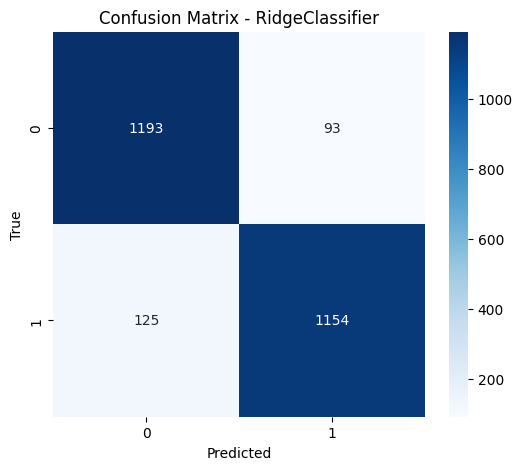

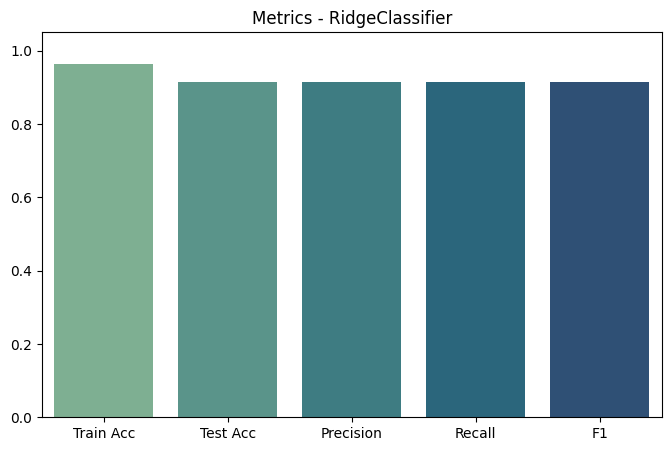

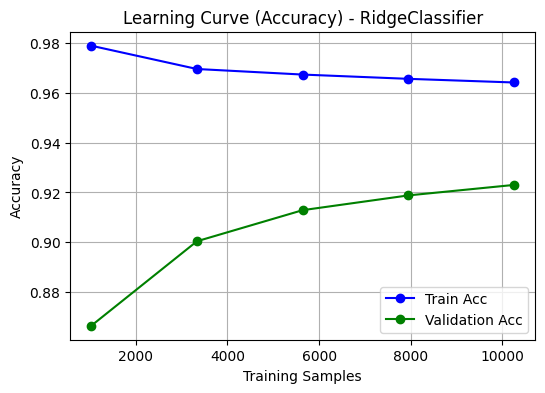

In [12]:
from sklearn.linear_model import RidgeClassifier

model_rc = RidgeClassifier(alpha=1.0, random_state=SEED, solver='lsqr')
evaluate_model_save_ml(model_rc, "RidgeClassifier", x_train_ml, x_test_ml, y_train_ml, y_test_ml)


# Passive Aggressive Classifier Training and Evaluation



===== PassiveAggressive (ML) =====
Train Accuracy : 0.9985
Test Accuracy  : 0.8947
Precision      : 0.8948
Recall         : 0.8947
F1 Score       : 0.8947
Runtime (sec)  : 0.39

Confusion Matrix (Text Output):
 [[1162  124]
 [ 146 1133]]


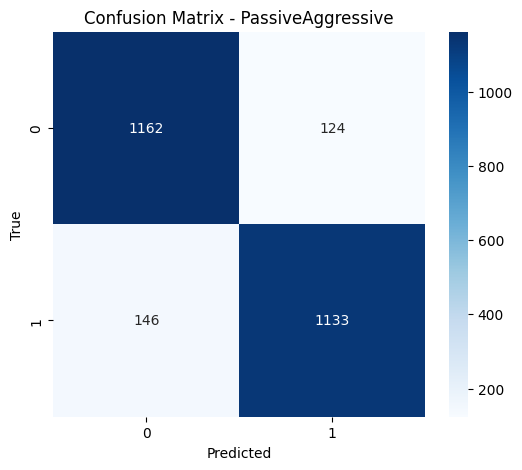

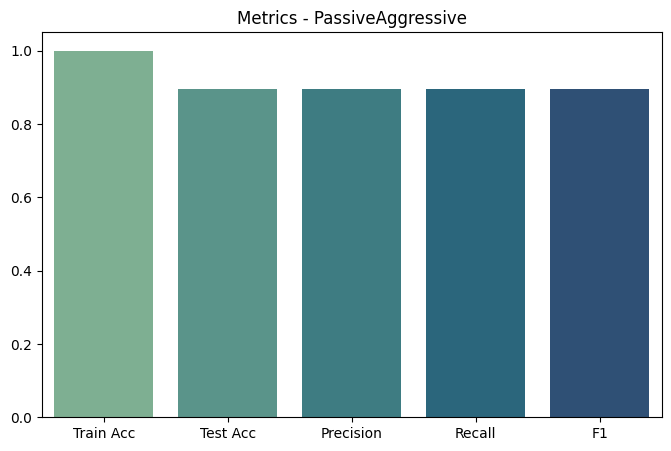

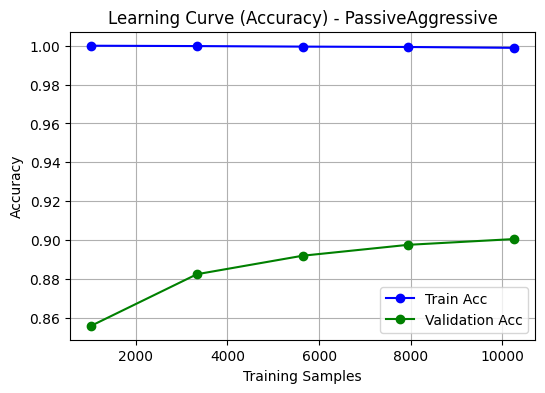

In [13]:
from sklearn.linear_model import PassiveAggressiveClassifier

model_pa = PassiveAggressiveClassifier(max_iter=1000, random_state=SEED, tol=1e-3)
evaluate_model_save_ml(model_pa, "PassiveAggressive", x_train_ml, x_test_ml, y_train_ml, y_test_ml)


# XGBoost Model Training and Evaluation



===== XGBoost (ML) =====
Train Accuracy : 0.9903
Test Accuracy  : 0.9037
Precision      : 0.9051
Recall         : 0.9037
F1 Score       : 0.9036
Runtime (sec)  : 32.41

Confusion Matrix (Text Output):
 [[1201   85]
 [ 162 1117]]


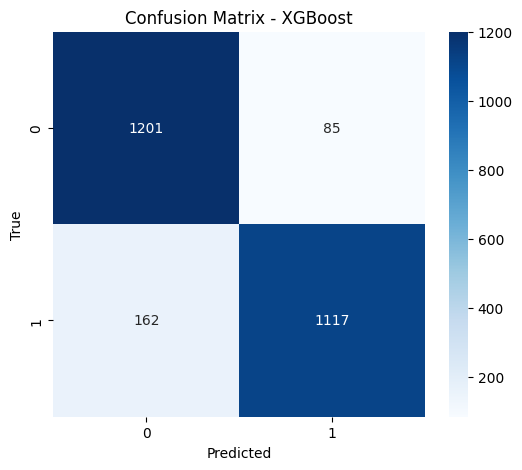

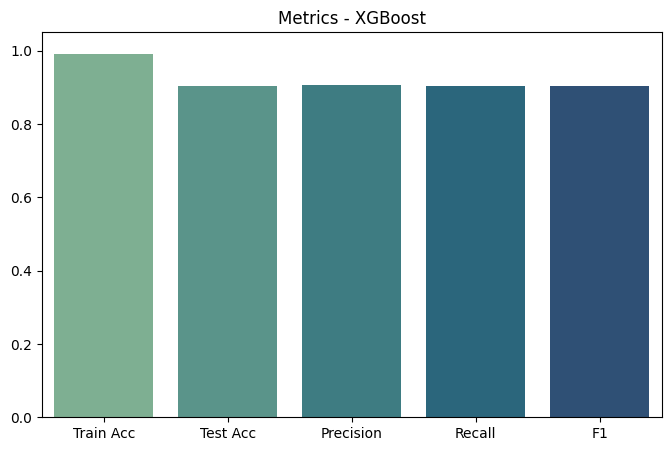

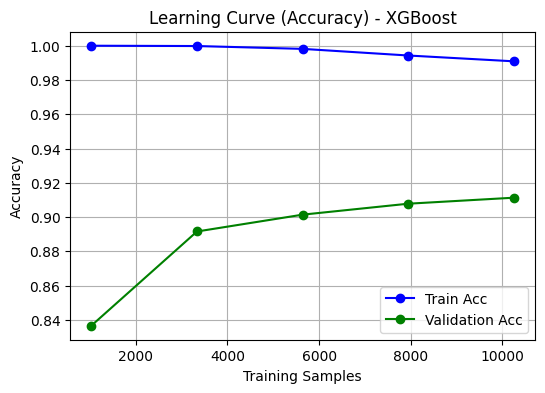

In [14]:
from xgboost import XGBClassifier

model_xgb = XGBClassifier(
    n_estimators=100,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=SEED
)

evaluate_model_save_ml(model_xgb, "XGBoost", x_train_ml, x_test_ml, y_train_ml, y_test_ml)


# Ensemble Hard Voting Model



===== Ensemble_HardVoting (ML) =====
Train Accuracy : 0.9699
Test Accuracy  : 0.9076
Precision      : 0.9092
Recall         : 0.9076
F1 Score       : 0.9075
Runtime (sec)  : 21.05

Confusion Matrix (Text Output):
 [[1208   78]
 [ 159 1120]]


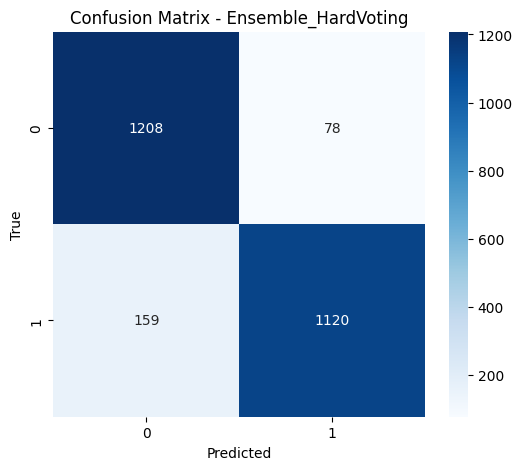

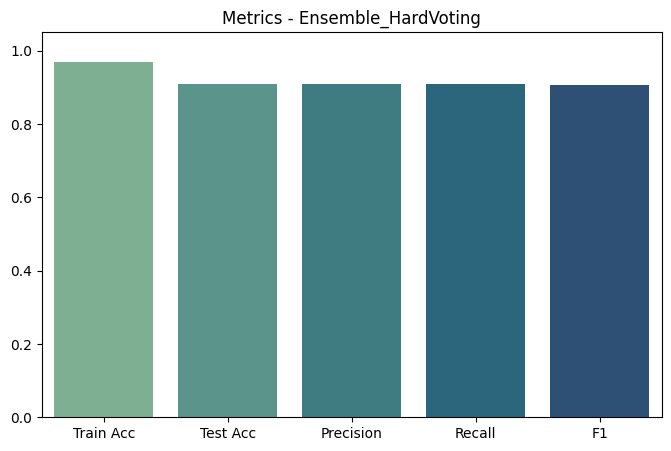

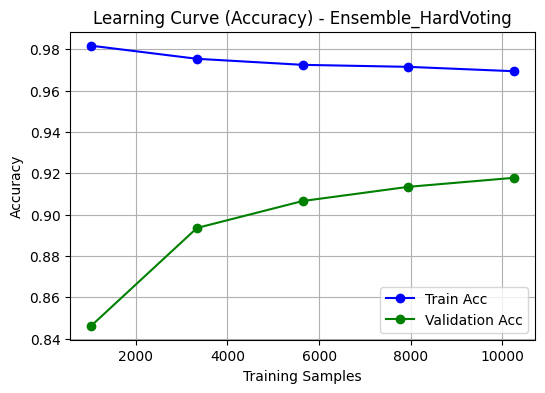

In [15]:
from sklearn.ensemble import VotingClassifier

# Use already defined models
ensemble_hard = VotingClassifier(
    estimators=[
        ('svc', model_svc),
        ('lr', model_lr),
        ('rf', model_rf),
        ('rc', model_rc),
    ],
    voting='hard'
)

evaluate_model_save_ml(ensemble_hard, "Ensemble_HardVoting", x_train_ml, x_test_ml, y_train_ml, y_test_ml)


# Model Evaluation for Deep Learning


In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def evaluate_model(model, x_test, y_test, history, model_name, threshold=0.5):
    # Predictions
    y_pred = (model.predict(x_test) > threshold).astype(int).flatten()
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print("\n📊 Model Performance:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # 1️⃣ Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.savefig(f"/kaggle/working/{model_name}_confusion_matrix.png")
    plt.show()
    
    # 2️⃣ Accuracy Curve (Train vs Val)
    plt.figure(figsize=(6,4))
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f"Accuracy Curve - {model_name}")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"/kaggle/working/{model_name}_accuracy_curve.png")
    plt.show()

    # 3️⃣ Loss Curve (Train vs Val)
    plt.figure(figsize=(6,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f"Loss Curve - {model_name}")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"/kaggle/working/{model_name}_loss_curve.png")
    plt.show()
    
    # 4️⃣ Bar Graph for Acc, Precision, Recall, F1
    metrics = [acc, prec, rec, f1]
    metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    plt.figure(figsize=(6,4))
    bars = plt.bar(metric_names, metrics, color=['skyblue', 'lightgreen', 'orange', 'pink'])
    plt.ylim(0,1)
    plt.title(f"Evaluation Metrics - {model_name}")
    
    for bar, value in zip(bars, metrics):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f"{value:.2f}", ha='center', va='bottom')
    
    plt.ylabel("Score")
    plt.savefig(f"/kaggle/working/{model_name}_metrics_bar.png")
    plt.show()


# BiLSTM Deep Learning Model


Epoch 1/7


I0000 00:00:1761026623.562922      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
2025-10-21 06:03:43.767497: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
I0000 00:00:1761026631.848744      89 cuda_dnn.cc:529] Loaded

145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6081 - loss: 0.7200

2025-10-21 06:03:57.579011: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


145/145 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - accuracy: 0.6084 - loss: 0.7199 - val_accuracy: 0.7281 - val_loss: 0.6186
Epoch 2/7
145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.7493 - loss: 0.5760 - val_accuracy: 0.8109 - val_loss: 0.4623
Epoch 3/7
145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.8314 - loss: 0.4237 - val_accuracy: 0.8908 - val_loss: 0.3324
Epoch 4/7
145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.9062 - loss: 0.2816 - val_accuracy: 0.9074 - val_loss: 0.3123
Epoch 5/7
145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.9356 - loss: 0.2097 - val_accuracy: 0.9142 - val_loss: 0.2733
Epoch 6/7
145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.9623 - loss: 0.1582 - val_accuracy: 0.9191 - val_loss: 0.2727
Epoch 7/7
145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.9712 - loss: 0.1341 - val_accuracy: 0.9250 - val_loss: 0.2702


2025-10-21 06:04:24.474574: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step

📊 Model Performance:
Accuracy: 0.9228
Precision: 0.9391
Recall: 0.9038
F1 Score: 0.9211


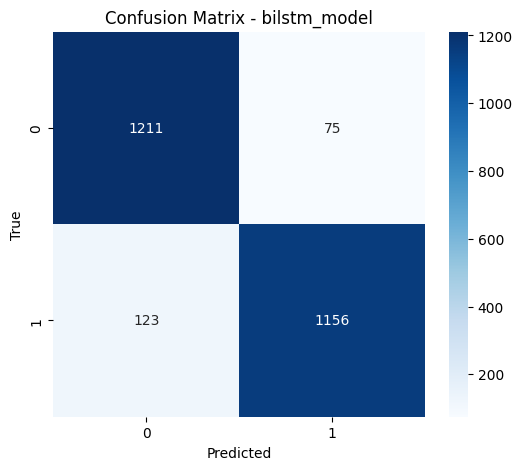

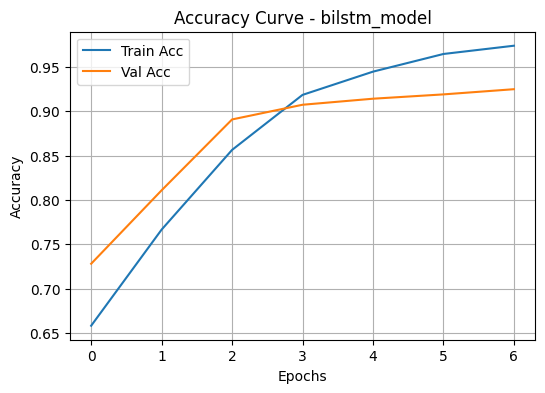

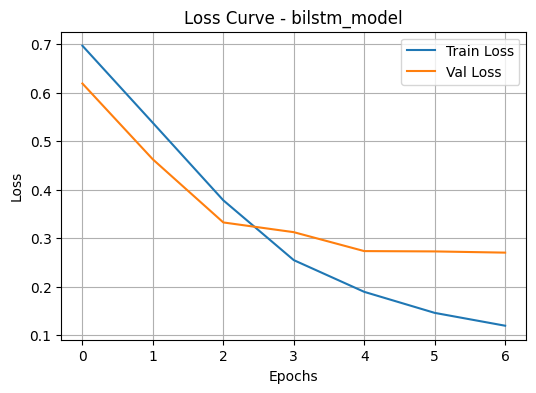

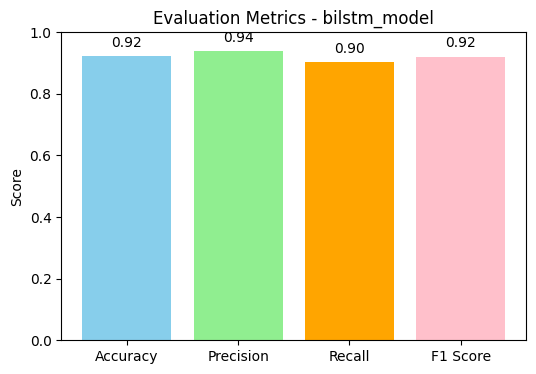

In [17]:
import os
import random
import warnings
import numpy as np
import tensorflow as tf
import pandas as pd
import re
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings("ignore")

SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

le = LabelEncoder()
y_enc = le.fit_transform(df['intention'])

max_words = 15000
max_len = 100
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df['Bangla'])
X_seq = tokenizer.texts_to_sequences(df['Bangla'])
X_pad = tf.keras.preprocessing.sequence.pad_sequences(X_seq, maxlen=max_len, padding='post', truncating='post')

x_train, x_test, y_train, y_test = train_test_split(X_pad, y_enc, test_size=0.2, random_state=SEED, stratify=y_enc)

bilstm_model = Sequential([
    Embedding(input_dim=max_words, output_dim=128,
              embeddings_initializer=tf.keras.initializers.GlorotUniform(seed=SEED)),
    Bidirectional(LSTM(32, return_sequences=True, kernel_regularizer=l2(1e-4),
                       recurrent_initializer=tf.keras.initializers.GlorotUniform(seed=SEED))),
    Dropout(0.2, seed=SEED),
    Bidirectional(LSTM(32, kernel_regularizer=l2(1e-4),
                       recurrent_initializer=tf.keras.initializers.GlorotUniform(seed=SEED))),
    Dropout(0.3, seed=SEED),
    Dense(32, activation='relu', kernel_regularizer=l2(1e-4),
          kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED)),
    Dense(1, activation='sigmoid',
          kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED))
])

bilstm_model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

history = bilstm_model.fit(
    x_train, y_train,
    validation_split=0.1,
    epochs=7,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1,
    shuffle=False
)

evaluate_model(bilstm_model, x_test, y_test, history,"bilstm_model")



# CNN Deep Learning Model


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ ?                           │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/7
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6318 - loss: 0.7063

2025-10-21 06:04:34.301799: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


145/145 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.6321 - loss: 0.7062 - val_accuracy: 0.6891 - val_loss: 0.6426
Epoch 2/7
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7253 - loss: 0.5803 - val_accuracy: 0.7856 - val_loss: 0.4833
Epoch 3/7
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8565 - loss: 0.3815 - val_accuracy: 0.8382 - val_loss: 0.3841
Epoch 4/7
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9106 - loss: 0.2685 - val_accuracy: 0.8470 - val_loss: 0.3831
Epoch 5/7
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9377 - loss: 0.2110 - val_accuracy: 0.8567 - val_loss: 0.3759
Epoch 6/7
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9512 - loss: 0.1741 - val_accuracy: 0.8558 - val_loss: 0.3898
Epoch 7/7
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9631 - loss: 0.1456 - val_accuracy: 0.8616 - val_loss: 0.3917
31/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  

2025-10-21 06:04:47.629670: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

📊 Model Performance:
Accuracy: 0.8503
Precision: 0.7954
Recall: 0.9421
F1 Score: 0.8626


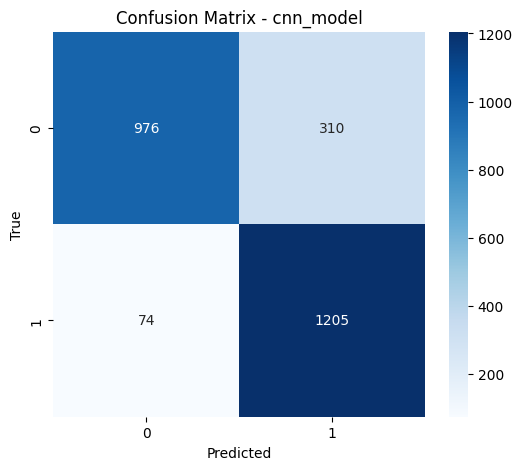

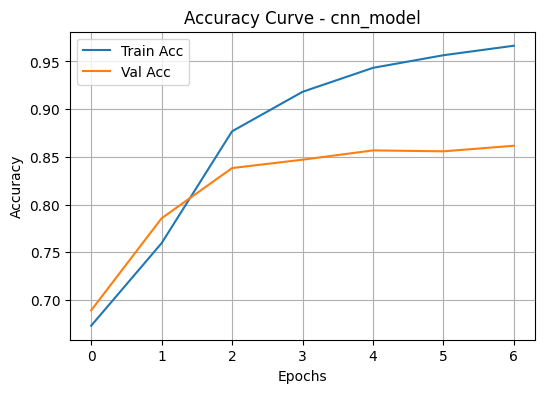

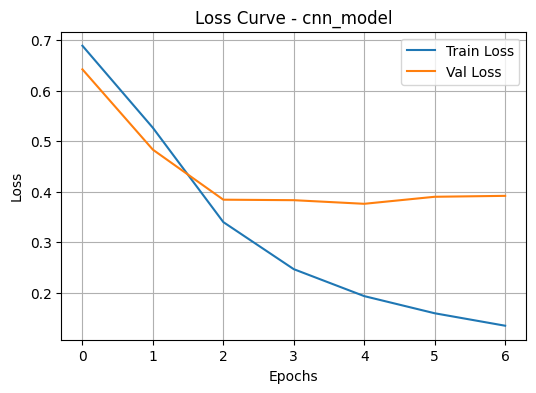

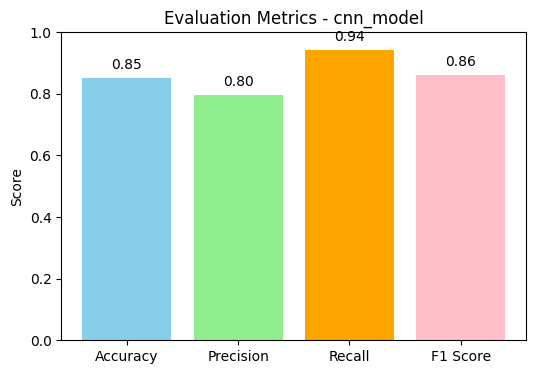

In [18]:
import os
import random
import warnings
import numpy as np
import tensorflow as tf
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings("ignore")

SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

le = LabelEncoder()
y_enc = le.fit_transform(df['intention'])

max_words = 35000
max_len = 100
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df['Bangla'])
X_seq = tokenizer.texts_to_sequences(df['Bangla'])
X_pad = tf.keras.preprocessing.sequence.pad_sequences(X_seq, maxlen=max_len, padding='post', truncating='post')

x_train, x_test, y_train, y_test = train_test_split(X_pad, y_enc, test_size=0.2, random_state=SEED, stratify=y_enc)

cnn_model = Sequential([
    Embedding(input_dim=max_words, output_dim=128,
              embeddings_initializer=tf.keras.initializers.GlorotUniform(seed=SEED)),
    
    Conv1D(filters=128, kernel_size=5, activation='relu', kernel_regularizer=l2(1e-4)),
    Dropout(0.3, seed=SEED),
    
    Conv1D(filters=32, kernel_size=3, activation='relu', kernel_regularizer=l2(1e-4)),
    GlobalMaxPooling1D(),
    
    Dense(64, activation='relu', kernel_regularizer=l2(1e-4)),
    Dropout(0.3, seed=SEED),
    
    Dense(1, activation='sigmoid')
])

cnn_model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

cnn_model.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = cnn_model.fit(
    x_train, y_train,
    validation_split=0.1,
    epochs=7,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1,
    shuffle=False
)

evaluate_model(cnn_model, x_test, y_test, history,"cnn_model")


# LSTM Model for Bangla Tweet Classification


Classes: [0. 1.]
Train/Test shapes: (10258, 100) (2565, 100)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/6
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5616 - loss: 0.6864

2025-10-21 06:04:56.024537: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


145/145 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.5619 - loss: 0.6863 - val_accuracy: 0.6277 - val_loss: 0.6744
Epoch 2/6
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6505 - loss: 0.6556 - val_accuracy: 0.7076 - val_loss: 0.5443
Epoch 3/6
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7201 - loss: 0.5396 - val_accuracy: 0.7037 - val_loss: 0.5427
Epoch 4/6
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7454 - loss: 0.5153 - val_accuracy: 0.7807 - val_loss: 0.5075
Epoch 5/6
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7970 - loss: 0.4508 - val_accuracy: 0.7632 - val_loss: 0.5080
Epoch 6/6
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8336 - loss: 0.4038 - val_accuracy: 0.8762 - val_loss: 0.3244
 1/81 ━━━━━━━━━━━━━━━━━━━━ 13s 164ms/step

2025-10-21 06:05:08.440535: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

📊 Model Performance:
Accuracy: 0.8713
Precision: 0.9310
Recall: 0.8014
F1 Score: 0.8613


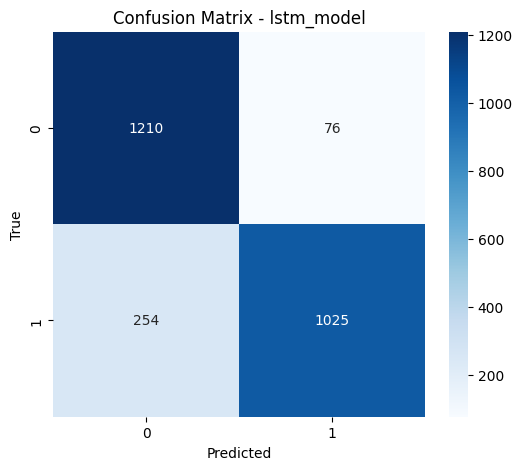

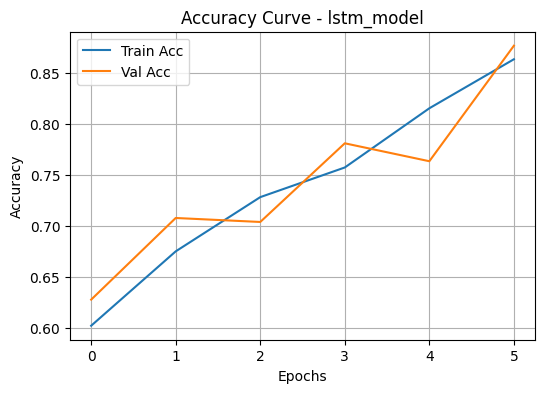

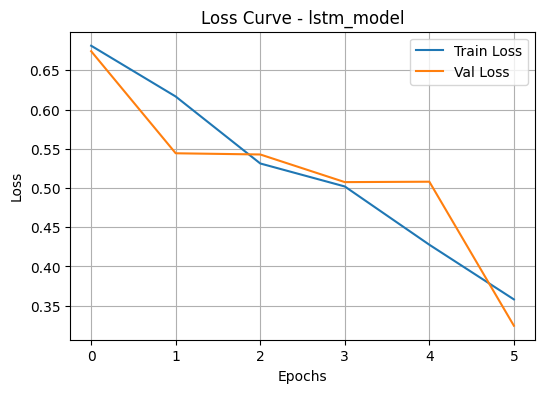

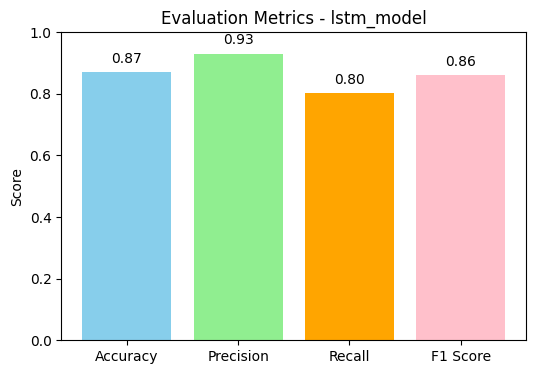

In [19]:
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score



le = LabelEncoder()
y_enc = le.fit_transform(df['intention'])
num_classes = len(le.classes_)
print("Classes:", le.classes_)

max_words = 45000
max_len = 100
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df['Bangla'])
X_seq = tokenizer.texts_to_sequences(df['Bangla'])
X_pad = pad_sequences(X_seq, maxlen=max_len, padding='post', truncating='post')

x_train, x_test, y_train, y_test = train_test_split(
    X_pad, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)
print("Train/Test shapes:", x_train.shape, x_test.shape)

lstm_model = Sequential([
    Embedding(input_dim=max_words, output_dim=128),
    LSTM(64, return_sequences=False),
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

lstm_model.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = lstm_model.fit(
    x_train, y_train,
    validation_split=0.1,
    epochs=6,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

evaluate_model(lstm_model, x_test, y_test, history,"lstm_model")


# GRU Model for Bangla Tweet Classification (Multi-GPU)


Using strategy: <tensorflow.python.distribute.distribute_lib._DefaultDistributionStrategy object at 0x7f5c894dc510>
Classes: [0. 1.]
Train/Test shapes: (10258, 40) (2565, 40)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/7
140/145 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6034 - loss: 0.6806

2025-10-21 06:05:15.665552: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6059 - loss: 0.6801 - val_accuracy: 0.7057 - val_loss: 0.6438
Epoch 2/7
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7152 - loss: 0.6230 - val_accuracy: 0.7164 - val_loss: 0.5537
Epoch 3/7
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7239 - loss: 0.5557 - val_accuracy: 0.7193 - val_loss: 0.5386
Epoch 4/7
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7393 - loss: 0.5263 - val_accuracy: 0.8099 - val_loss: 0.4170
Epoch 5/7
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8360 - loss: 0.3996 - val_accuracy: 0.8889 - val_loss: 0.2895
Epoch 6/7
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8997 - loss: 0.2787 - val_accuracy: 0.8996 - val_loss: 0.2628
Epoch 7/7
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9285 - loss: 0.2168 - val_accuracy: 0.9045 - val_loss: 0.2625
25/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step   

2025-10-21 06:05:23.406306: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

📊 Model Performance:
Accuracy: 0.8881
Precision: 0.8798
Recall: 0.8984
F1 Score: 0.8890


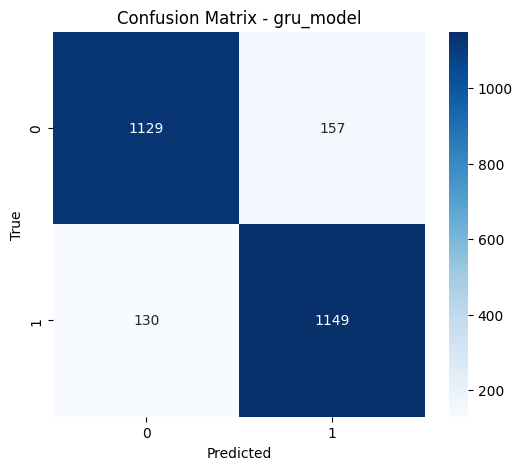

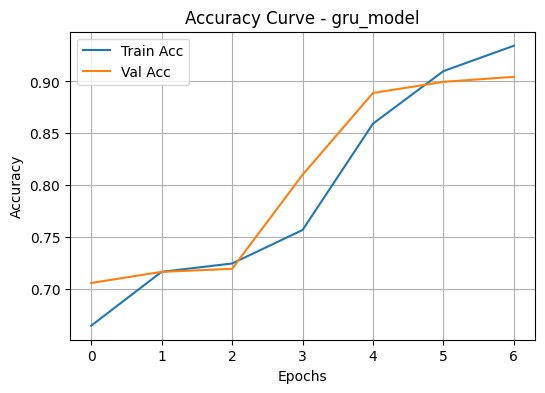

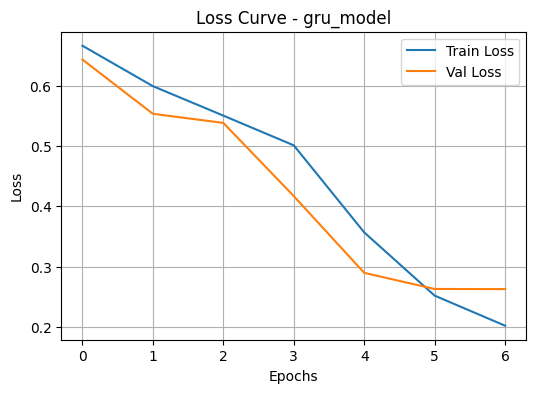

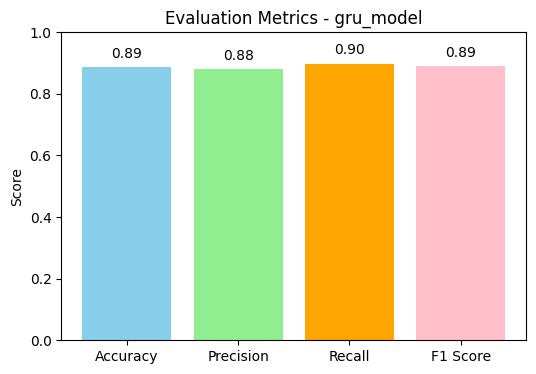

In [20]:
import os
import random
import warnings
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings("ignore")

SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

gpus = tf.config.list_physical_devices('GPU')
if len(gpus) > 1:
    strategy = tf.distribute.MirroredStrategy()
else:
    strategy = tf.distribute.get_strategy()
print(f"Using strategy: {strategy}")

le = LabelEncoder()
y_enc = le.fit_transform(df['intention'])
print("Classes:", le.classes_)

max_words = 4000
max_len = 40
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df['Bangla'])
X_seq = tokenizer.texts_to_sequences(df['Bangla'])
X_pad = tf.keras.preprocessing.sequence.pad_sequences(X_seq, maxlen=max_len, padding='post', truncating='post')

x_train, x_test, y_train, y_test = train_test_split(
    X_pad, y_enc, test_size=0.2, random_state=SEED, stratify=y_enc
)
print("Train/Test shapes:", x_train.shape, x_test.shape)

with strategy.scope():
    gru_model = Sequential([
        Embedding(input_dim=max_words, output_dim=128,
                  embeddings_initializer=tf.keras.initializers.GlorotUniform(seed=SEED)),
        GRU(64, return_sequences=False,
            kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED),
            recurrent_initializer=tf.keras.initializers.GlorotUniform(seed=SEED)),
        Dropout(0.3, seed=SEED),
        Dense(32, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED)),
        Dropout(0.3, seed=SEED),
        Dense(1, activation='sigmoid', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED))
    ])

    gru_model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        metrics=['accuracy']
    )

gru_model.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

history = gru_model.fit(
    x_train, y_train,
    validation_split=0.1,
    epochs=7,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1,
    shuffle=False
)

evaluate_model(gru_model, x_test, y_test, history,"gru_model")


# ✅ Results & Conclusion


**Summary:**  
- Individual models trained and evaluated successfully  
- Deep learning models showed strong performance on Bangla tweet classification  
- Ensemble improved robustness and overall performance  
- Visualizations include confusion matrices and metric bar charts  

**Next Steps:**  
- Experiment with hyperparameter tuning for each deep learning model  
- Try more advanced ensemble strategies (weighted voting, stacking)  
- Explore multi-class classification if more intention categories are added  
